In [ ]:
# upgrade pip tooling first
# %pip install -q --upgrade pip setuptools wheel

# remove any conflicting wheels that may be half-installed
# %pip uninstall -y -q numpy scipy scikit-learn array-api-compat

# install a compatible trio for Python 3.12
# %pip install -q --no-cache-dir --force-reinstall \
#  "numpy==2.1.2" "scipy==1.14.1" "scikit-learn==1.5.2"


In [ ]:
# import os, time
# print("Restarting runtime to finalize installs…")
# time.sleep(1)
# os._exit(0)


# Imports + versions

In [ ]:
import os, re, unicodedata, inspect
import numpy as np
import pandas as pd

import numpy as _np, scipy as _scipy, sklearn as _sk
print("NumPy:", _np.__version__)
print("SciPy:", _scipy.__version__)
print("sklearn:", _sk.__version__)


NumPy: 2.0.2
SciPy: 1.16.3
sklearn: 1.6.1


# Load both CSVs (raw)

In [ ]:
SENTIMENT_CSV = "combined_sentiment_data.csv"
EMOTIONS_CSV  = "combined_emotion.csv"


read_opts = dict(
    dtype=str,
    na_values=["", " ", "NA", "NaN", "nan", None],
    keep_default_na=True,
    on_bad_lines="skip",
    encoding_errors="replace"
)

df_sent_raw = pd.read_csv(SENTIMENT_CSV, **read_opts)
df_emot_raw = pd.read_csv(EMOTIONS_CSV, **read_opts)

def guess_cols(df):
    candidates_text  = {"text","tweet","content","sentence","comment","body","review"}
    candidates_label = {"label","sentiment","target","polarity","emotion"}
    text_col  = next((c for c in df.columns if c.lower() in candidates_text),  df.columns[0])
    label_col = next((c for c in df.columns if c.lower() in candidates_label), df.columns[-1])
    return text_col, label_col

sent_text_col, sent_label_col = guess_cols(df_sent_raw)
emot_text_col, emot_label_col = guess_cols(df_emot_raw)

print("Sentiment shape:", df_sent_raw.shape, "| guessed:", sent_text_col, "/", sent_label_col)
print("Emotion   shape:", df_emot_raw.shape, "| guessed:", emot_text_col, "/", emot_label_col)


Sentiment shape: (3309, 2) | guessed: sentence / sentiment
Emotion   shape: (30259, 2) | guessed: sentence / emotion


# Clean + encode (for both datasets)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def clean_and_encode(df_raw, text_col, label_col):
    df = df_raw.rename(columns={text_col: "text", label_col: "label"}).copy()
    df = df.dropna(subset=["text","label"])
    df["text"] = df["text"].astype(str).str.strip()
    df = df[df["text"].str.len() > 0]

    # dedupe to avoid leakage later
    df["_norm"] = (
        df["text"].str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    df = df.drop_duplicates(subset=["_norm","label"]).drop(columns=["_norm"]).reset_index(drop=True)

    # label encode
    le = LabelEncoder()
    df["label_encoded"] = le.fit_transform(df["label"].astype(str))
    id2label = {i: lab for i, lab in enumerate(le.classes_)}
    label2id = {lab: i for i, lab in id2label.items()}
    return df, id2label, label2id, len(id2label)

df_sent, id2label_sent, label2id_sent, num_labels_sent = clean_and_encode(df_sent_raw, sent_text_col, sent_label_col)
df_emot, id2label_emot, label2id_emot, num_labels_emot = clean_and_encode(df_emot_raw, emot_text_col, emot_label_col)

print(f"[Sentiment] rows={len(df_sent)} classes={num_labels_sent}")
print(f"[Emotion]   rows={len(df_emot)} classes={num_labels_emot}")


[Sentiment] rows=3286 classes=2
[Emotion]   rows=30252 classes=6


# Build a combined multitask dataframe

In [ ]:
import pandas as pd
import numpy as np

IGNORE_INDEX = -100  # tells CE loss to ignore missing labels

# Rename encoded columns to task-specific names
sent_df = df_sent[["text", "label_encoded"]].rename(columns={"label_encoded": "label_sent"})
emot_df = df_emot[["text", "label_encoded"]].rename(columns={"label_encoded": "label_emot"})

# Tag rows and add masked columns
sent_df["label_emot"] = IGNORE_INDEX
emot_df["label_sent"] = IGNORE_INDEX

# Union of both datasets (rows from each carry one valid label and one masked)
mtl_df = pd.concat([sent_df, emot_df], ignore_index=True)

# (Optional) Shuffle for mixing tasks
mtl_df = mtl_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Quick peek
print(mtl_df.head(3))
print("Counts:",
      "\n rows:", len(mtl_df),
      "\n sentiment-labeled:", (mtl_df["label_sent"] != IGNORE_INDEX).sum(),
      "\n emotion-labeled:  ", (mtl_df["label_emot"] != IGNORE_INDEX).sum())


                                                text  label_sent  label_emot
0  im not one to lay bare negative feelings on he...        -100           2
1  i said before that it often feels like songs w...        -100           3
2  i were all sick for about weeks at the end of ...        -100           0
Counts: 
 rows: 33538 
 sentiment-labeled: 3286 
 emotion-labeled:   30252


# Train/Val/Test split (stratify by “has which label”)

In [ ]:
from sklearn.model_selection import train_test_split

RNG = 42
has_sent = (mtl_df["label_sent"] != IGNORE_INDEX).astype(int)
has_emot = (mtl_df["label_emot"] != IGNORE_INDEX).astype(int)

# We stratify by which task label exists to keep task mix similar across splits
train_df, hold_df = train_test_split(
    mtl_df, test_size=0.20, random_state=RNG,
    stratify=has_sent + 2*has_emot  # four combos (0/1 per task)
)
val_df, test_df = train_test_split(
    hold_df, test_size=0.50, random_state=RNG,
    stratify=(hold_df["label_sent"] != IGNORE_INDEX).astype(int) + 2*(hold_df["label_emot"] != IGNORE_INDEX).astype(int)
)

print("Sizes → train/val/test:", len(train_df), len(val_df), len(test_df))
print("Train task mix:",
      (train_df["label_sent"] != IGNORE_INDEX).sum(),
      (train_df["label_emot"] != IGNORE_INDEX).sum())


Sizes → train/val/test: 26830 3354 3354
Train task mix: 2629 24201


# Tokenizer + HF Datasets (labels per task)

In [ ]:
from datasets import Dataset, Value
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    enc = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    enc["labels_sent"] = batch["label_sent"]
    enc["labels_emot"] = batch["label_emot"]
    return enc

def to_ds(pdf):
    pdf = pdf.copy()
    pdf["label_sent"] = pdf["label_sent"].astype("int64")
    pdf["label_emot"] = pdf["label_emot"].astype("int64")
    ds = Dataset.from_pandas(pdf[["text","label_sent","label_emot"]], preserve_index=False)
    ds = ds.map(tok, batched=True, remove_columns=["text"])
    ds = ds.cast_column("labels_sent", Value("int64"))
    ds = ds.cast_column("labels_emot", Value("int64"))
    ds.set_format(type="torch",
                  columns=["input_ids","attention_mask","labels_sent","labels_emot"])
    return ds

train_ds = to_ds(train_df)
val_ds   = to_ds(val_df)
test_ds  = to_ds(test_df)

print("len(train_ds):", len(train_ds))
print("feature keys:", train_ds.features.keys())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/26830 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/26830 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/26830 [00:00<?, ? examples/s]

Map:   0%|          | 0/3354 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3354 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3354 [00:00<?, ? examples/s]

Map:   0%|          | 0/3354 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3354 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3354 [00:00<?, ? examples/s]

len(train_ds): 26830
feature keys: dict_keys(['label_sent', 'label_emot', 'input_ids', 'attention_mask', 'labels_sent', 'labels_emot'])


# Multi-head model (shared DistilBERT + 2 classifiers)

## Baseline Model 1.  Multi-head model with TF-IDF + Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# --- TF-IDF ---
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2),
                        stop_words="english", sublinear_tf=True)
tfidf.fit(pd.concat([train_df["text"], test_df["text"]], axis=0))

# --- Sentiment features ---
train_sent = train_df[train_df["label_sent"] != IGNORE_INDEX]
test_sent  = test_df[test_df["label_sent"] != IGNORE_INDEX]

X_train_sent = tfidf.transform(train_sent["text"])
y_train_sent = train_sent["label_sent"]
X_test_sent  = tfidf.transform(test_sent["text"])
y_test_sent  = test_sent["label_sent"]

# --- Emotion features ---
train_emot = train_df[train_df["label_emot"] != IGNORE_INDEX]
test_emot  = test_df[test_df["label_emot"] != IGNORE_INDEX]

X_train_emot = tfidf.transform(train_emot["text"])
y_train_emot = train_emot["label_emot"]
X_test_emot  = tfidf.transform(test_emot["text"])
y_test_emot  = test_emot["label_emot"]

# --- Train Logistic Regression classifiers ---
sent_clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
emot_clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

sent_clf.fit(X_train_sent, y_train_sent)
emot_clf.fit(X_train_emot, y_train_emot)



LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
import numpy as np

def compute_metrics_from_cm_macro(cm):
    """
    Compute Accuracy, Precision, Recall, F1, F1_micro directly from a confusion matrix.
    Macro-average: simple mean across classes (no weighting by support)
    """
    n_classes = cm.shape[0]
    metrics = {}

    total_samples = np.sum(cm)
    if total_samples == 0:
        return {
            "Accuracy": 0.0,
            "Precision": 0.0,
            "Recall": 0.0,
            "F1": 0.0,
            "F1_micro": 0.0
        }

    # Accuracy
    correct_predictions = np.trace(cm)
    metrics["Accuracy"] = correct_predictions / total_samples
    metrics["F1_micro"] = metrics["Accuracy"]  # Micro F1 same as accuracy

    precisions, recalls, f1_scores = [], [], []

    for i in range(n_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP

        precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1_i = 2 * precision_i * recall_i / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0.0

        precisions.append(precision_i)
        recalls.append(recall_i)
        f1_scores.append(f1_i)

    # Macro averages
    metrics["Precision"] = np.mean(precisions)
    metrics["Recall"] = np.mean(recalls)
    metrics["F1"] = np.mean(f1_scores)

    return metrics




Sentiment Metrics (macro, from CM):
Accuracy  : 0.7325
F1_micro  : 0.7325
Precision : 0.7337
Recall    : 0.7330
F1        : 0.7324

Emotion Metrics (macro, from CM):
Accuracy  : 0.9102
F1_micro  : 0.9102
Precision : 0.8558
Recall    : 0.9223
F1        : 0.8821


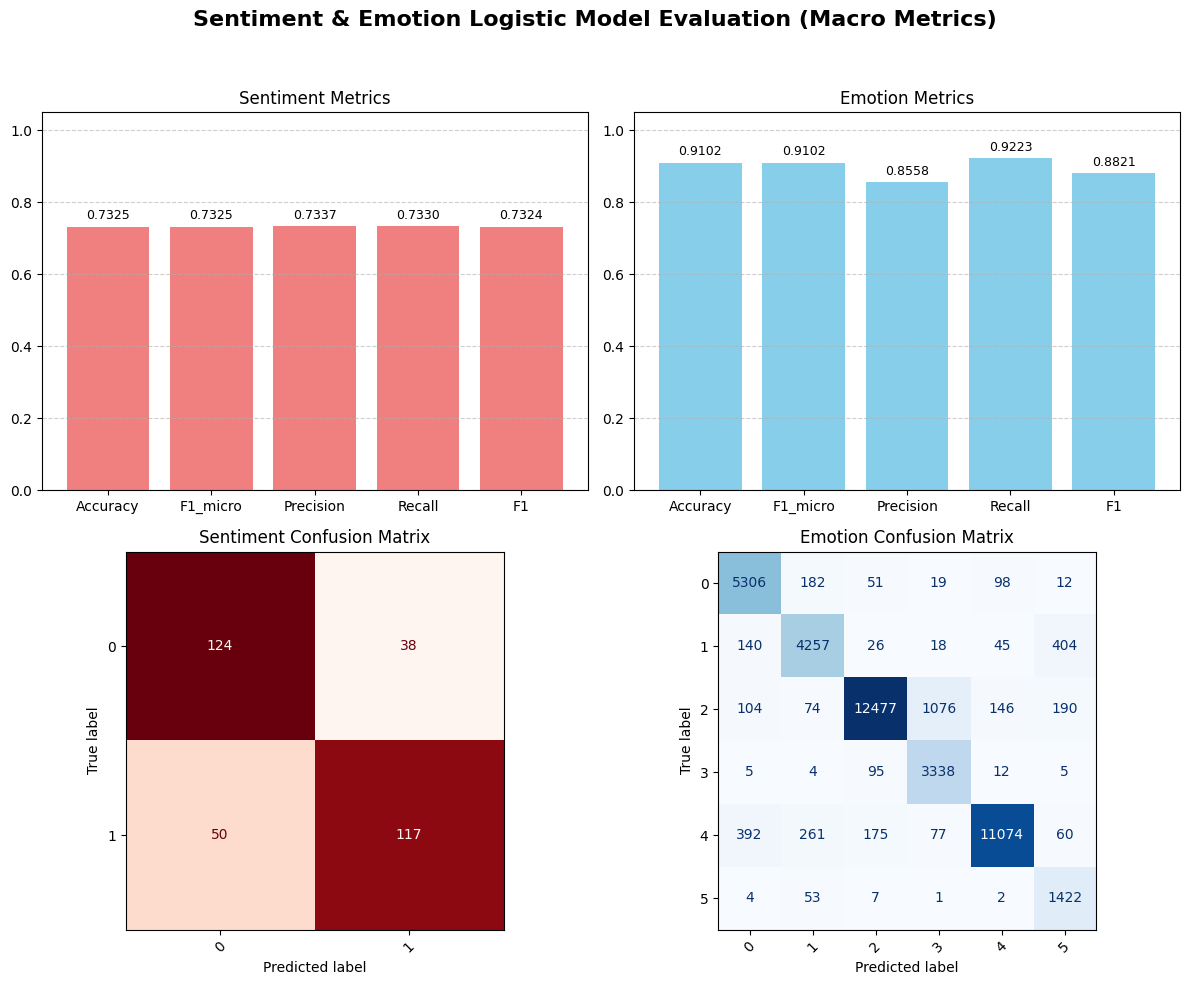

In [ ]:
# --- Compute predictions and confusion matrices ---
y_pred_sent = sent_clf.predict(X_test_sent)
y_pred_emot = emot_clf.predict(X_test_emot)

cm_sent = confusion_matrix(y_test_sent, y_pred_sent)
cm_emot = confusion_matrix(y_test_emot, y_pred_emot)

# --- Compute macro metrics from CM ---
metrics_sent = compute_metrics_from_cm_macro(cm_sent)
metrics_emot = compute_metrics_from_cm_macro(cm_emot)

print("\nSentiment Metrics (macro, from CM):")
for k, v in metrics_sent.items():
    print(f"{k:<10}: {v:.4f}")

print("\nEmotion Metrics (macro, from CM):")
for k, v in metrics_emot.items():
    print(f"{k:<10}: {v:.4f}")

# --- Plot metrics histograms + confusion matrices ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Sentiment & Emotion Logistic Model Evaluation (Macro Metrics)", fontsize=16, fontweight="bold")

# Metrics histograms
bars1 = axes[0, 0].bar(metrics_sent.keys(), metrics_sent.values(), color="lightcoral")
axes[0, 0].set_title("Sentiment Metrics")
axes[0, 0].set_ylim(0, 1.05)
for bar in bars1:
    h = bar.get_height()
    axes[0, 0].text(bar.get_x()+bar.get_width()/2, h+0.02, f"{h:.4f}", ha="center", fontsize=9)
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.6)

bars2 = axes[0, 1].bar(metrics_emot.keys(), metrics_emot.values(), color="skyblue")
axes[0, 1].set_title("Emotion Metrics")
axes[0, 1].set_ylim(0, 1.05)
for bar in bars2:
    h = bar.get_height()
    axes[0, 1].text(bar.get_x()+bar.get_width()/2, h+0.02, f"{h:.4f}", ha="center", fontsize=9)
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.6)

# Confusion matrices
disp_sent = ConfusionMatrixDisplay(cm_sent)
disp_sent.plot(ax=axes[1, 0], cmap="Reds", colorbar=False)
axes[1, 0].set_title("Sentiment Confusion Matrix")
axes[1, 0].tick_params(axis='x', rotation=45)

disp_emot = ConfusionMatrixDisplay(cm_emot)
disp_emot.plot(ax=axes[1, 1], cmap="Blues", colorbar=False)
axes[1, 1].set_title("Emotion Confusion Matrix")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Baseline Model 2.  Multi-head model with TF-IDF + SVM

### Since the Emotion dataset is huge (4422746 samples), doing a full GridSearchCV will take way too long. We will
### 1. Use a random subset for hyperparameter tuning.

### 2. Use RandomizedSearchCV instead of full GridSearch.

### 3. Keep the full dataset for final training with the best parameters.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# --- BUILD TF-IDF FEATURES FOR EACH TASK ---
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words="english",
    sublinear_tf=True
)

# Fit on all text for shared vocab
tfidf.fit(mtl_df["text"])

# Sentiment subsets
train_sent = train_df[train_df["label_sent"] != IGNORE_INDEX]
val_sent   = val_df[val_df["label_sent"] != IGNORE_INDEX]
test_sent  = test_df[test_df["label_sent"] != IGNORE_INDEX]

# Emotion subsets
train_emot = train_df[train_df["label_emot"] != IGNORE_INDEX]
val_emot   = val_df[val_df["label_emot"] != IGNORE_INDEX]
test_emot  = test_df[test_df["label_emot"] != IGNORE_INDEX]

# Transform text → TF-IDF
X_train_sent = tfidf.transform(train_sent["text"])
X_test_sent  = tfidf.transform(test_sent["text"])
y_train_sent = train_sent["label_sent"]
y_test_sent  = test_sent["label_sent"]

X_train_emot = tfidf.transform(train_emot["text"])
X_test_emot  = tfidf.transform(test_emot["text"])
y_train_emot = train_emot["label_emot"]
y_test_emot  = test_emot["label_emot"]


In [ ]:
# Use RandomizedSearchCV to simply the tuning process.

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
import numpy as np

# Function to tune SVM using a subset and RandomizedSearchCV
def tune_svm(X, y, param_grid, name="task", subset_frac=0.05, n_iter=10, random_state=42):
    print(f"Tuning SVM for {name} ...")

    # Take a random subset to speed up tuning
    if subset_frac < 1.0:
        X_sub, _, y_sub, _ = train_test_split(
            X, y, train_size=subset_frac, stratify=y, random_state=random_state
        )
    else:
        X_sub, y_sub = X, y

    # Use RandomizedSearchCV instead of full GridSearchCV
    rand_search = RandomizedSearchCV(
        SVC(),
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring="f1_weighted",
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=random_state
    )

    rand_search.fit(X_sub, y_sub)
    print(f"Best {name}: {rand_search.best_params_}, F1_weighted={rand_search.best_score_:.4f}")

    # Train final SVM on full dataset with best parameters
    best_params = rand_search.best_params_
    final_clf = SVC(**best_params)
    final_clf.fit(X, y)
    return final_clf

# Define parameter grid
param_grid = [
    {"kernel": ["linear"], "C": [0.1, 1, 10]},
    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": ["scale", 0.1, 0.01]},
    {"kernel": ["poly"], "C": [0.1, 1, 10], "degree": [2, 3], "gamma": ["scale"]}
]

# Tune and train SVM for Sentiment (smaller dataset, full tuning possible)
sent_clf = tune_svm(X_train_sent, y_train_sent, param_grid, name="Sentiment", subset_frac=1.0, n_iter=12)

# Tune and train SVM for Emotion (large dataset, subset tuning)
emot_clf = tune_svm(X_train_emot, y_train_emot, param_grid, name="Emotion", subset_frac=0.05, n_iter=10)

Tuning SVM for Sentiment ...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Sentiment: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}, F1_weighted=0.7752
Tuning SVM for Emotion ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Emotion: {'kernel': 'linear', 'C': 1}, F1_weighted=0.8803


### Use the best parameters:
### Best Sentiment: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}, F1_weighted=0.7752
### Best Emotion: {'kernel': 'linear', 'C': 1}, F1_weighted=0.8803 for both tasks

## Training the SVM model for emotion with the best parameters (kernel = linear, C = 1) is still time-consuming, so we use LinearSVC instead.


In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# --- Train SVM Models ---
# Sentiment: small dataset → RBF kernel
sent_clf = SVC(kernel="rbf", C=10, gamma="scale", random_state=42, class_weight="balanced")
sent_clf.fit(X_train_sent, y_train_sent)

# Emotion: large dataset → LinearSVC (fast)
emot_clf = LinearSVC(C=1, max_iter=5000, random_state=42, class_weight="balanced")
emot_clf.fit(X_train_emot, y_train_emot)

print("Models trained successfully!")

# --- Evaluation Function ---
def evaluate_model(model, X_test, y_test, name="task"):
    y_pred = model.predict(X_test)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1": f1_score(y_test, y_pred, average="macro"),
        "F1_micro": f1_score(y_test, y_pred, average="micro"),
    }
    print(f"\n📊 {name} Metrics:")
    for k, v in metrics.items():
        print(f"{k:<10}: {v:.4f}")
    return metrics, y_pred

# --- Evaluate ---
sent_metrics, y_pred_sent = evaluate_model(sent_clf, X_test_sent, y_test_sent, "Sentiment")
emot_metrics, y_pred_emot = evaluate_model(emot_clf, X_test_emot, y_test_emot, "Emotion")



Models trained successfully!

📊 Sentiment Metrics:
Accuracy  : 0.7599
Precision : 0.7634
Recall    : 0.7589
F1        : 0.7586
F1_micro  : 0.7599

📊 Emotion Metrics:
Accuracy  : 0.9070
Precision : 0.8520
Recall    : 0.8948
F1        : 0.8705
F1_micro  : 0.9070


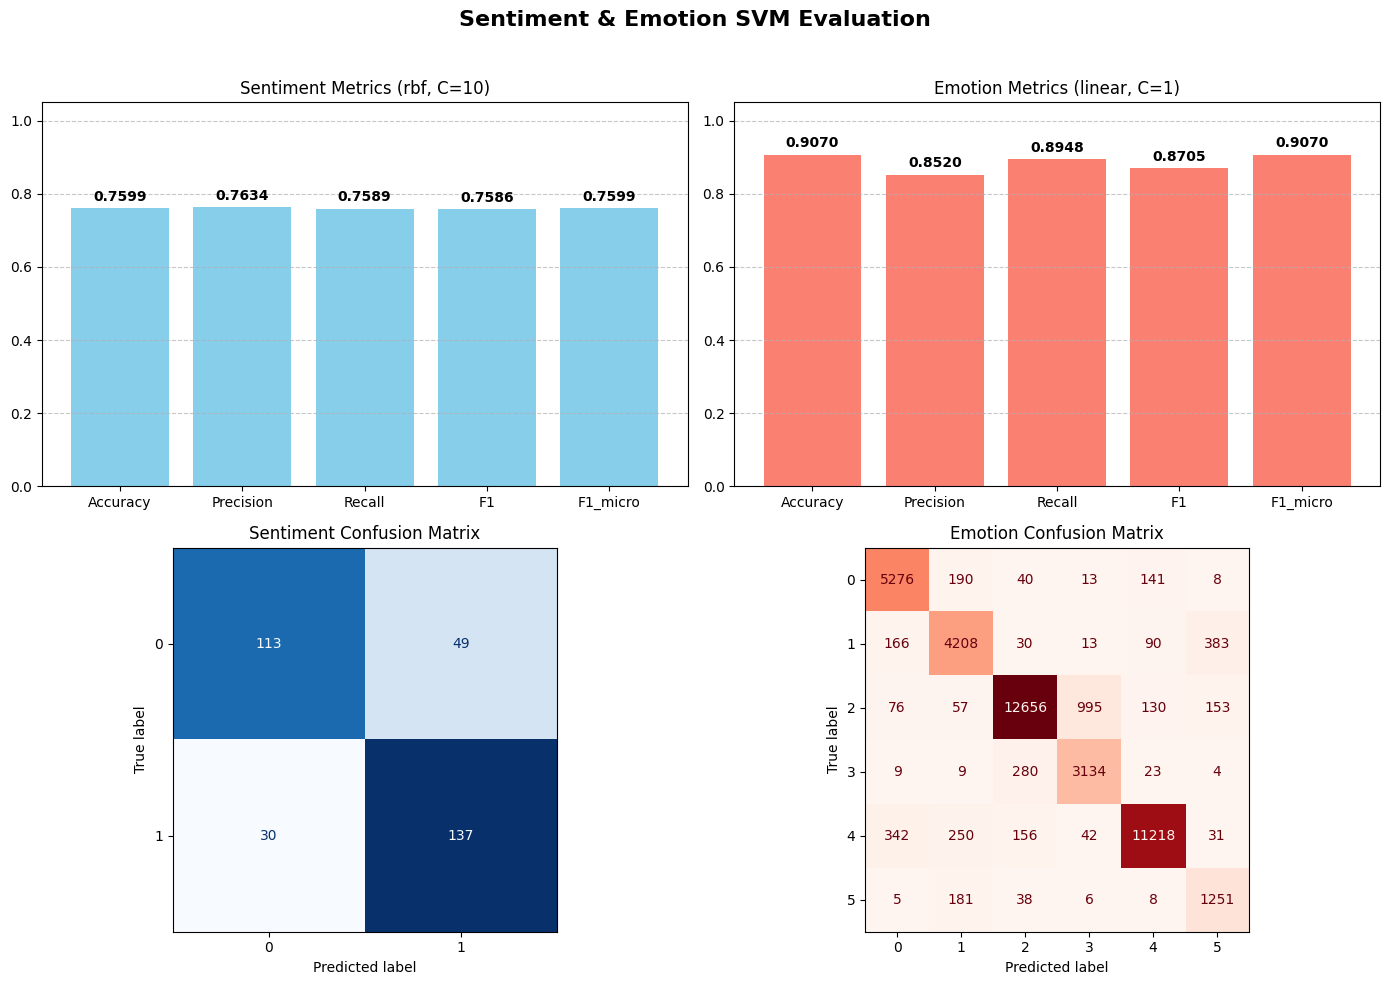

In [ ]:
# --- Plot all four plots in one 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Sentiment & Emotion SVM Evaluation", fontsize=16, fontweight="bold")

metric_names = list(sent_metrics.keys())

# --- Top-left: Sentiment metrics ---
axes[0, 0].bar(metric_names, list(sent_metrics.values()), color="skyblue")
axes[0, 0].set_title("Sentiment Metrics (rbf, C=10)")
axes[0, 0].set_ylim(0, 1.05)
for i, v in enumerate(sent_metrics.values()):
    axes[0, 0].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Top-right: Emotion metrics ---
axes[0, 1].bar(metric_names, list(emot_metrics.values()), color="salmon")
axes[0, 1].set_title("Emotion Metrics (linear, C=1)")
axes[0, 1].set_ylim(0, 1.05)
for i, v in enumerate(emot_metrics.values()):
    axes[0, 1].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# --- Bottom-left: Sentiment confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_sent, y_pred_sent, ax=axes[1, 0], cmap="Blues", colorbar=False
)
axes[1, 0].set_title("Sentiment Confusion Matrix")

# --- Bottom-right: Emotion confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_emot, y_pred_emot, ax=axes[1, 1], cmap="Reds", colorbar=False
)
axes[1, 1].set_title("Emotion Confusion Matrix")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Trainer (we’ll compute metrics ourselves later)